# Imbalancing and Splitting Dataset
We will split and imbalance our dataset. We split the data into test and training sets and also ensure imbalance across categories. This will help us focus on where to augment our data.

### A note on directory structure
We assume our data is structed by labels. For instance, a directory should contain `LABEL/data{1..n}.gif`.

In [1]:
from functools import reduce
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split

In [2]:
# Enable reproducible results
np.random.seed(123)

In [3]:
def load_data(root_dir, label_load_percent=1.0, glob_pattern='./**/*.JPEG', path_label_idx=2):
    path = Path(root_dir)
    labeled_dirs = [x.glob(glob_pattern) for x in path.iterdir() if x.is_dir()]
    
    # Shuffle our labeled paths
    np.random.shuffle(labeled_dirs)
    
    # Take only the specified percentage
    last = int(len(labeled_dirs) * label_load_percent)
    labeled_dirs = labeled_dirs[:last]
    
    # Load all data paths
    data_paths = reduce(list.__add__, [[y for y in x if y.is_file()] for x in labeled_dirs])
    
    labels = [x.parts[path_label_idx] for x in data_paths]
    
    return (data_paths, labels)

In [4]:
X,y = load_data('./tiny-imagenet-200/train')

In [5]:
input_df = pd.DataFrame({'X': X, 'y': y})
input_df

,X,y
0,tiny-imagenet-200/train/n04067472/images/n0406...,n04067472
1,tiny-imagenet-200/train/n04067472/images/n0406...,n04067472
2,tiny-imagenet-200/train/n04067472/images/n0406...,n04067472
3,tiny-imagenet-200/train/n04067472/images/n0406...,n04067472
4,tiny-imagenet-200/train/n04067472/images/n0406...,n04067472
...,...,...
99995,tiny-imagenet-200/train/n02056570/images/n0205...,n02056570
99996,tiny-imagenet-200/train/n02056570/images/n0205...,n02056570
99997,tiny-imagenet-200/train/n02056570/images/n0205...,n02056570
99998,tiny-imagenet-200/train/n02056570/images/n0205...,n02056570


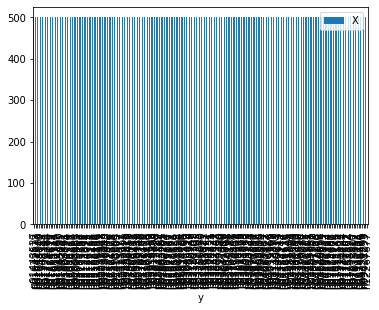

In [6]:
# Plot a histogram of our sample to class distribution
input_df.groupby('y').count().plot(kind='bar')

In [7]:
# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
# Calculate bounds for throwing data away
PCT_CAT_TO_IMBALANCE = 0.01
LOWER_BOUND_IMBALANCE = 0.30
UPPER_BOUND_IMBALANCE = 0.60

unique_labels = list(set(y_train))
num_cats_to_imbalance = int(len(unique_labels) * PCT_CAT_TO_IMBALANCE)
np.random.shuffle(unique_labels)
imbalance_categories = unique_labels[:num_cats_to_imbalance]

print("Imbalancing categories: {}".format(imbalance_categories))

Imbalancing categories: ['n01882714', 'n04562935']


In [9]:
# Throw away random samples
X_train_imbal = None
y_train_imbal = None
for cat in imbalance_categories:
    imbalance_pct = np.random.uniform(LOWER_BOUND_IMBALANCE, UPPER_BOUND_IMBALANCE)

    print("Imbalancing {} with percent: {}".format(cat, imbalance_pct))
    
    indices = [x for x in range(len(y_train)) if y_train[x] == cat]
    np.random.shuffle(indices)
    num_to_discard = int(len(indices) * imbalance_pct)
    indices = indices[:num_to_discard]

    X_train_imbal = [X_train[x] for x in range(len(X_train)) if x not in indices]
    y_train_imbal = [y_train[x] for x in range(len(y_train)) if x not in indices]

Imbalancing n01882714 with percent: 0.5460941268401921
Imbalancing n04562935 with percent: 0.4880741265889713


In [10]:
imbalanced_df = pd.DataFrame({'X': X_train_imbal, 'y': y_train_imbal})
imbalanced_df

,X,y
0,tiny-imagenet-200/train/n02769748/images/n0276...,n02769748
1,tiny-imagenet-200/train/n02927161/images/n0292...,n02927161
2,tiny-imagenet-200/train/n07695742/images/n0769...,n07695742
3,tiny-imagenet-200/train/n03026506/images/n0302...,n03026506
4,tiny-imagenet-200/train/n02814533/images/n0281...,n02814533
...,...,...
69818,tiny-imagenet-200/train/n04540053/images/n0454...,n04540053
69819,tiny-imagenet-200/train/n02843684/images/n0284...,n02843684
69820,tiny-imagenet-200/train/n09193705/images/n0919...,n09193705
69821,tiny-imagenet-200/train/n02423022/images/n0242...,n02423022


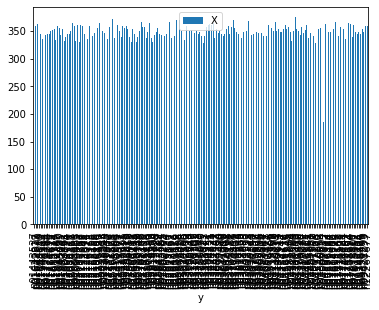

In [11]:
imbalanced_df.groupby('y').count().plot(kind='bar')

In [12]:
# Output expected test and train file:
def write_metadata(filename, X, y):
    assert(len(X) == len(y))
    with open(filename, 'w') as f:
        for i in range(len(X)):
            f.write('{}\t{}\n'.format(X[i], y[i]))

In [13]:
write_metadata('./metadata_output/test_metadata.txt', X_test, y_test)

In [14]:
write_metadata('./metadata_output/train_metadata.txt', X_train, y_train)

In [15]:
# Quick sanity check to make sure things weren't oddly manipulated (i.e. incorrect manipulation of label to data)
for i in range(len(X_train)):
    assert(str(y_train[i]) in str(X_train[i]))
for i in range(len(X_test)):
    assert(str(y_test[i]) in str(X_test[i]))